

<center><table>
<tr>

<th> <img src= "INL1.png",align="middle",style="width: 10000px;"/> </th>
</tr>
<tr>
<th> <img src="PennNucDataCenter.jpeg"  ,align="middle", style="width: 500px;"/> </th>
</tr>
<center><table>

# <center>Nuclear-Powered Data Centers Economic Optimization Strategy</center>

#### Expected Outcome
- A journal paper evaluating <u>the economic threshold points</u> identifying the conditions under which user requirements would be better suited by a large, small, or micro-reactor. The use case will be focused on data centers and will provide INL with the credential to stake a claim as a leader in nuclear for data center research.

- With a framework on hand, the lab could then leverage its expertise to offer advisory support for the various data centers considering nuclear energy. Further, with interest growing in this area, it is possible that DOE-NE would sponsor research on coupling nuclear reactors with data centers. INL would be well positioned to lead such R&D activities.

#### Activity
- A framework is proposed to evaluate the **economic tradeoff** between large, small, and micro-reactors. 
- The intent is to map out ‘threshold values’ under a given set of requirements 
  - energy demand size
  - reliability 
  
- The framework would parametrize a set of important economic variables to quantifiably differentiate the different reactor classes. 
  - nuclear capacity
  - diseconomies of scale, 
   - economies of mass production, 
   - speed of deployment, 
   - downtime intervals  



### Required Imports

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from src import *
from scipy import signal
import sk_dsp_comm.sigsys as ss
import statistics



/tmp/ipykernel_2719838/911928288.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
# # Fuel lifetime estimation at each power 
# power_range = [1, 1000]
# fuelCycle_range = [30*12*2, 30*12*5]
# fuelCycle_interp = sp.interpolate.interp1d( power_range,  fuelCycle_range )

# ppp = 5 # MWe
# fuelCycle_estimated = int((fuelCycle_interp(ppp ))/30)

## The schedule for one reactor

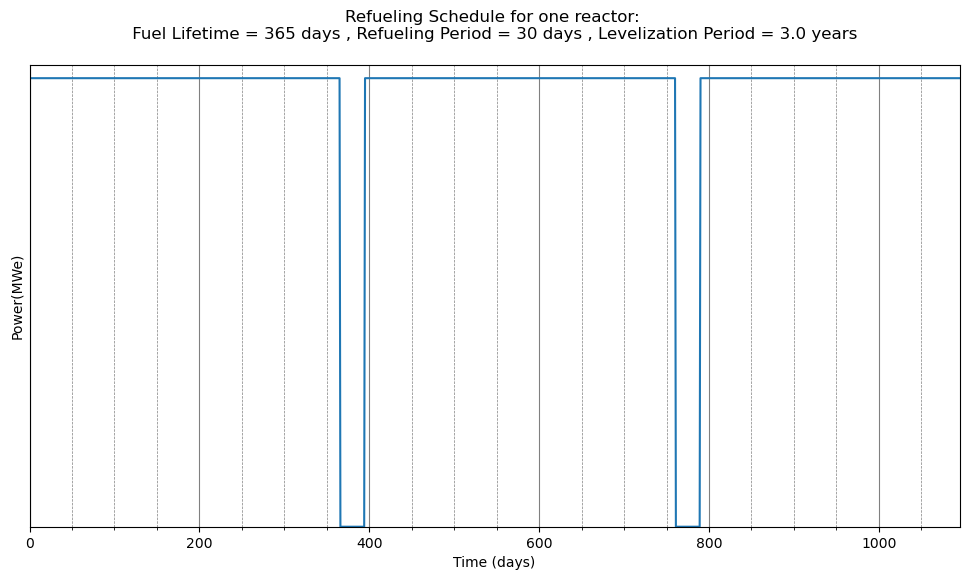

In [2]:
fig = plt.figure(figsize=(12, 6))
power = 300 # MWe
fuel_lifetime = 1*365 # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 3*365 # in days
inital_delay = 0

t_list = []
P_list = []
for time in range(levelization_period+1):
    P = calculate_duty_cycle( inital_delay, fuel_lifetime, refueling_period, levelization_period, power, time)
    t_list.append(time)
    P_list.append(P)



plt.plot(t_list, P_list)
plt.xlim(0, levelization_period)
plt.ylim(0, 1.03*power)
plt.xlabel('Time (days)')
plt.ylabel('Power(MWe)')

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.gca().yaxis.set_major_locator(plt.NullLocator())



plt.title(f"Refueling Schedule for one reactor: \n Fuel Lifetime = {np.round(fuel_lifetime, 1)} days , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
plt.show()

## The schedule for 2 reactors
The second reactor should start after the first reactor with a delay equals 1 refueling period. This way we guarantee that:
1. Both reactors will never be off at the same time, 
2- Use the full power of the two reactors ASAP


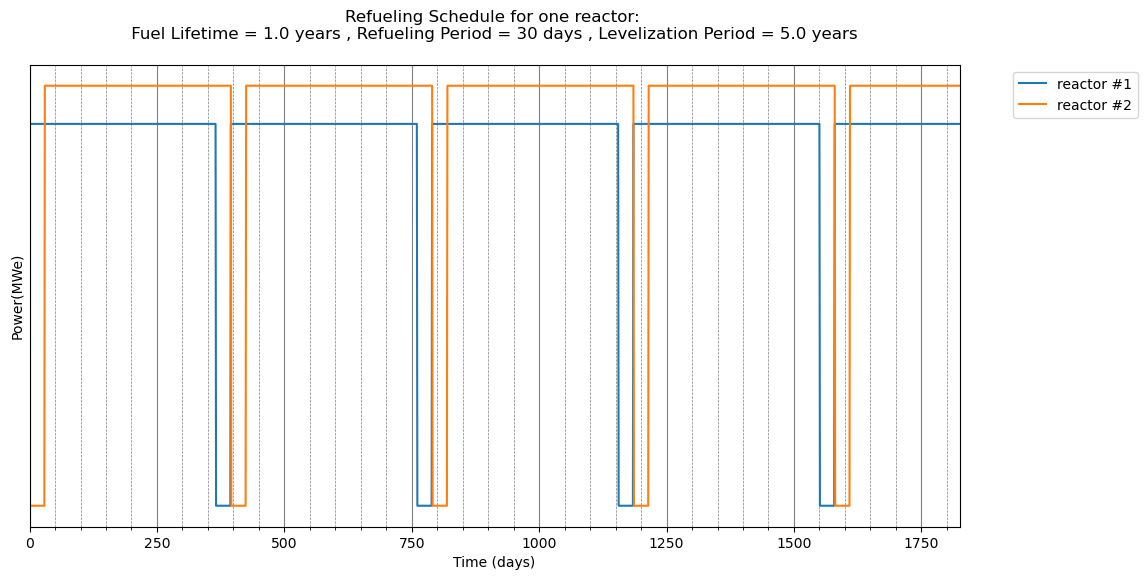

In [3]:
fig = plt.figure(figsize=(12, 6))
power = 300 # MWe
fuel_lifetime = 1*365 # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 5*365 # in days
inital_delay1 = 0
inital_delay2 = refueling_period 

t_list = []
P_list1 = []
P_list2 = []
for time in range(levelization_period+1):
    P1 = calculate_duty_cycle( inital_delay1, fuel_lifetime, refueling_period, levelization_period, power, time)
    t_list.append(time)
    P_list1.append(P1)
    P2 = calculate_duty_cycle( inital_delay2, fuel_lifetime, refueling_period, levelization_period, 1.1*power, time) # I change the power her for visualization
    if P2 == 0:
        if P1 ==0:
            print("WARNING: P2 = 0 and P1 =0")
    P_list2.append(P2)

plt.plot(t_list, P_list1, label = "reactor #1")
plt.plot(t_list, P_list2, label = "reactor #2")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim(0, levelization_period)

plt.xlabel('Time (days)')
plt.ylabel('Power(MWe)')

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.title(f"Refueling Schedule for one reactor: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  \le \frac{fuel \, Lifetime}{Refueling \, Period} $

An example for visualization (not realistic):
- fuel lifetime = 4 months
- refueling period = 1 months
- number of reactors = 4

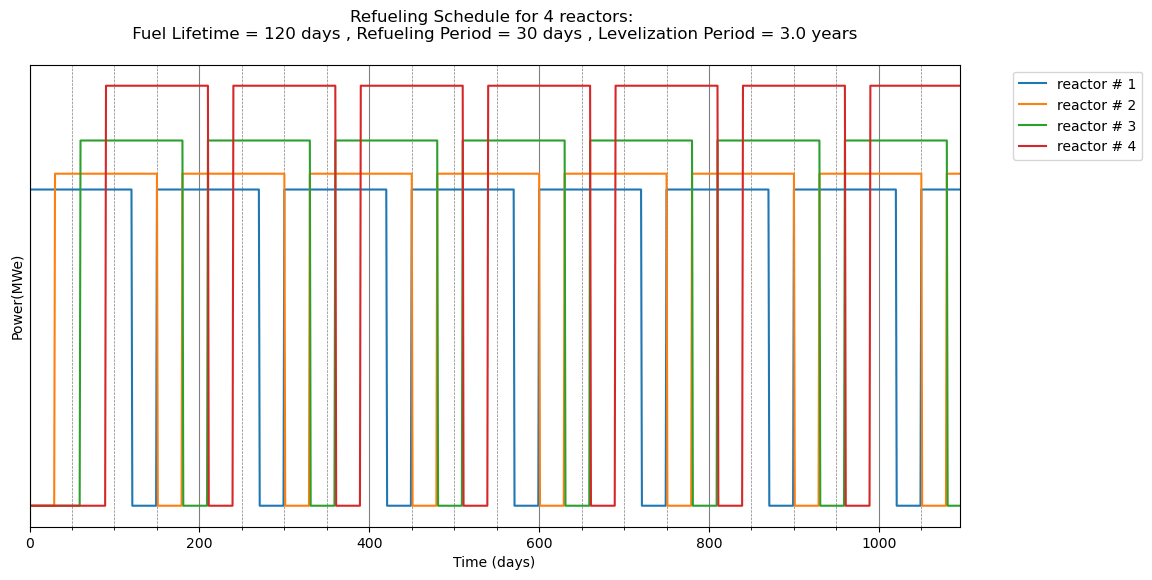

startup period  =  90.0 days


In [4]:
fig = plt.figure(figsize=(12, 6))
power = 100 # MWe
fuel_lifetime = int(4*30) # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 3*365 # in days

num_reactors = 4

initial_delay_list =list(refueling_period*np.linspace(0,  num_reactors-1, num_reactors) )
P_list_tot = []
for i in range(len(initial_delay_list)):
    
    delay = initial_delay_list[i] 
    power = power *(1+ i *0.05) # just for visualization
    
    t_list = []
    P_list = []

    for time in range(levelization_period+1):
       
        P = calculate_duty_cycle( int( delay), fuel_lifetime, refueling_period, levelization_period, power, time)
      
        t_list.append(time)
        P_list.append(P)

    P_list_tot.append(P_list)

    plt.plot(t_list, P_list, label = f"reactor # {i+1}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlim(0, levelization_period)
    plt.xlabel('Time (days)')
    plt.ylabel('Power(MWe)')

    plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime, 1)} days , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
  
plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
plt.show()

print( "startup period  = ", initial_delay_list[-1], "days")

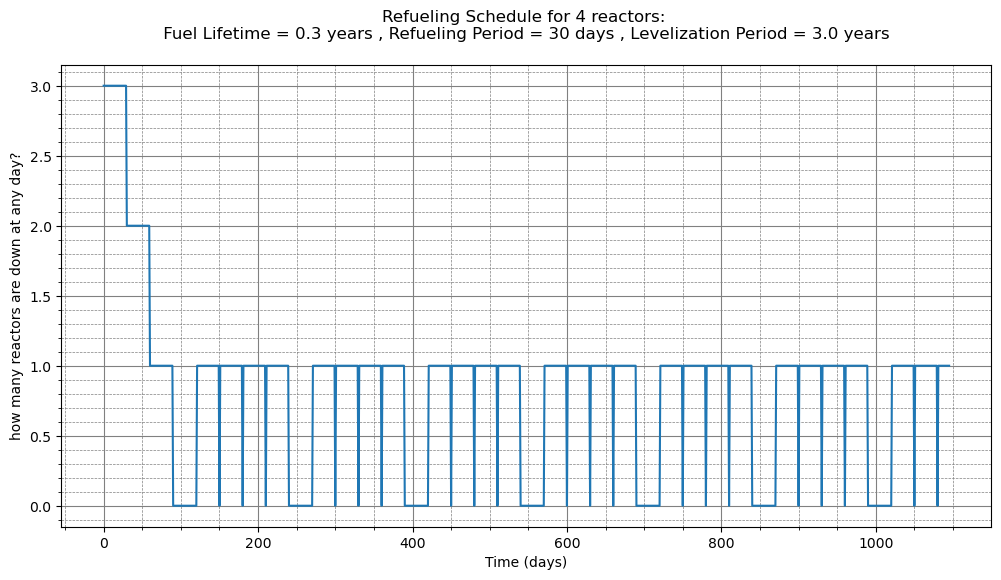

In [5]:
fig = plt.figure(figsize=(12, 6))

P_list_tot_array = (np.vstack(P_list_tot))
reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))

plt.plot(t_list,  reactors_down_list) 
plt.xlabel('Time (days)')
plt.ylabel('how many reactors are down at any day?')
plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  > \frac{fuel \, Lifetime}{Refueling \, Period} $

An example for visualization (not realistic):
- fuel lifetime = 4 months
- refueling period = 1 months
- number of reactors = 7

Since the total number of refueling  = 1 months * 7 reactors = 7 months which is longer than the fuel lifetime which is 4 months, this means that more than one reactor has to be down at sometime

Using increments of 1 months (the refueling period), all the reactors have to be refueled within one cycle.
The number of reactos to be refueled at the same time $= \frac{7}{4}  = 1\frac{3}{4} $

-Therefore, 2 reactors will be refueled each month (in the first 3 months) and 1 reactor is refueled in the 4th month

<br>


This can be formulated as follows
- $number \, of\, reactors \, down \, at \, one\,  refueling\, period \in  [ Ceiling[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}] \, , \, Floor[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}]] $

    - The number of refueling period where the ceiling value is taken is :  $ \frac {modulus(num \, of \, reactors \, \times \, refueling \, period \, , \, refueling \, period) }{refueling \, period}$

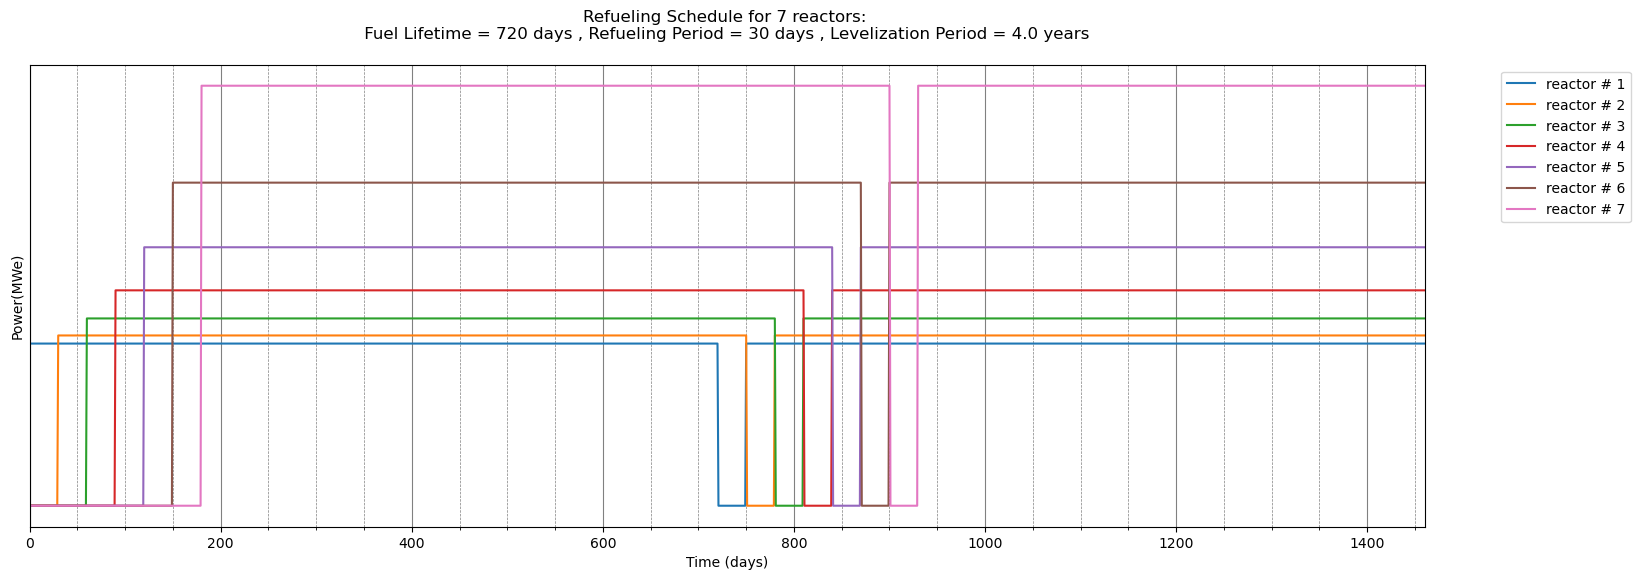

startup period  =  180.0 days


In [6]:
fig = plt.figure(figsize=(18, 6))


power = 100 # MWe
fuel_lifetime = int(24*30) # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 4*365 # in days

num_reactors = 7
num_reactors_down_max = int(np.ceil(num_reactors * refueling_period/fuel_lifetime))
num_reactors_down_min = int(np.floor(num_reactors * refueling_period/fuel_lifetime))

# how many times the celing value is used
num_reactors_down_max_freq = int(np.ceil((num_reactors * refueling_period )% fuel_lifetime)/refueling_period) 
num_reactors_down_min_freq = int(fuel_lifetime /refueling_period)- num_reactors_down_max_freq

reactor_down_list1 = [num_reactors_down_max ]*num_reactors_down_max_freq
reactor_down_list2 = [num_reactors_down_min ]*num_reactors_down_min_freq
reactor_down_list = reactor_down_list1  + reactor_down_list2

assert len(reactor_down_list  ) == int(fuel_lifetime/refueling_period ) , "There is an assertion error. review!"

initial_delay_list = []
for n in np.linspace(0,  int(fuel_lifetime/refueling_period )-1, int(fuel_lifetime/refueling_period )):

    delay_list = [n*refueling_period] * reactor_down_list [int(n)]
    initial_delay_list.append(delay_list )
initial_delay_list = list(np.hstack(initial_delay_list))


P_list_tot = []
for i in range(len(initial_delay_list)):
    
    delay = initial_delay_list[i] 
    power = power *(1+ i *0.05) # just for visualization
    
    t_list = []
    P_list = []

    for time in range(levelization_period+1):
       
        P = calculate_duty_cycle( int( delay), fuel_lifetime, refueling_period, levelization_period, power, time)
      
        t_list.append(time)
        P_list.append(P)

    P_list_tot.append(P_list)

    plt.plot(t_list, P_list, label = f"reactor # {i+1}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlim(0, levelization_period)
    plt.xlabel('Time (days)')
    plt.ylabel('Power(MWe)')

    plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime, 1)} days , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.show()

print( "startup period  = ", initial_delay_list[-1], "days")

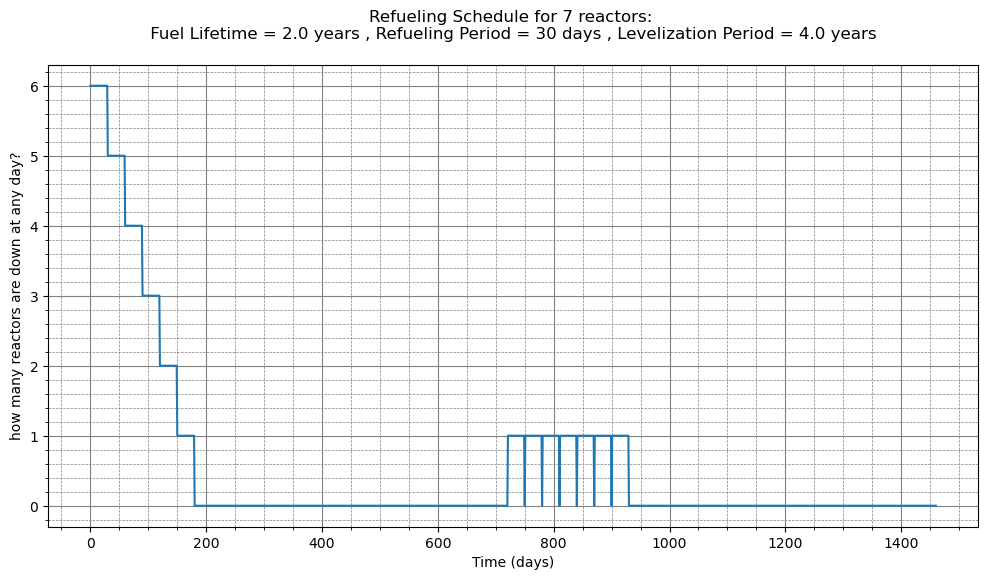

In [7]:
fig = plt.figure(figsize=(12, 6))

P_list_tot_array = (np.vstack(P_list_tot))
reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))

plt.plot(t_list,  reactors_down_list) 
plt.xlabel('Time (days)')
plt.ylabel('how many reactors are down at any day?')
plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()


# General Example (should work for any variables)

ramp up to full power period  =  690.0 days


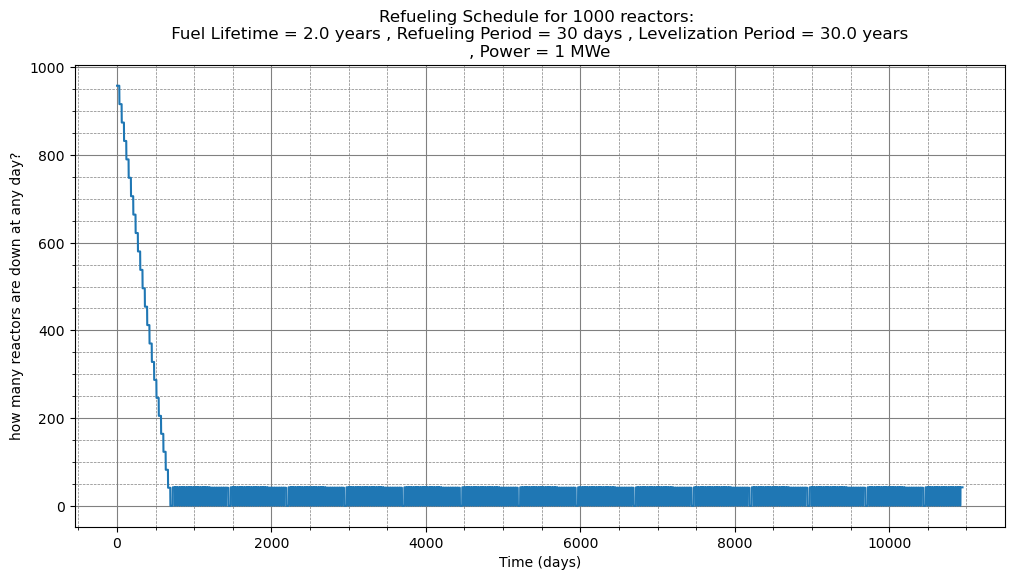

In [8]:
fig = plt.figure(figsize=(12, 6))

fuel_lifetime = 30 *24 # days
refueling_period = 30 # days
num_reactors = 1000
power1 = 1
levelization_period = 30*365
schedule = calculate_schedule_multiple_reactors(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period) 
times =  schedule[0]
powers =  schedule[1]

# for n in range(len(powers)): # i can plot this but it is hard to see!
#     plt.plot(times, powers[n] )


P_list_tot_array = (np.vstack(powers))

reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))


plt.plot(times,  reactors_down_list) 
plt.xlabel('Time (days)')
plt.ylabel('how many reactors are down at any day?')
plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n, Power = {power1} MWe")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

print( "ramp up to full power period  = ", schedule[2], "days")

# Capacity factor (An example: 1 MW microreactor, 1000 reactors)

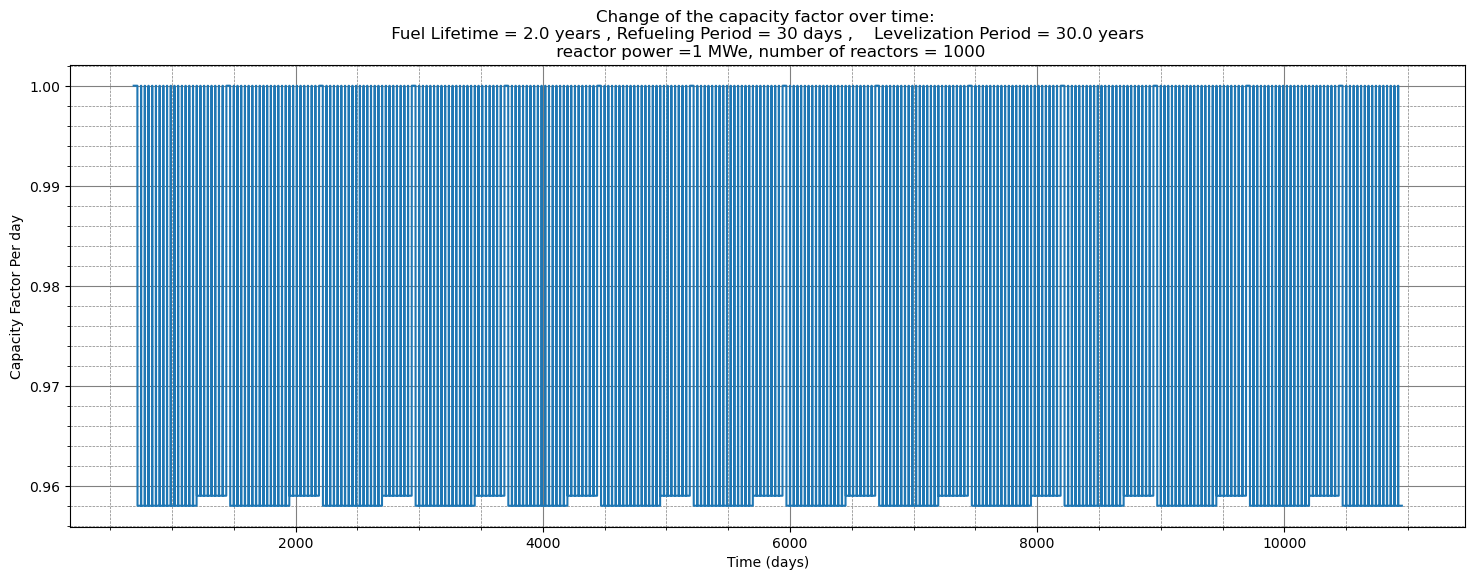

Capacity Factor over the plant lifetime is : 0.9613556183607835


In [9]:
fig = plt.figure(figsize=(18, 6))

# # remove the data before getting to the full power
times_array =np.reshape(np.array(times) , (1, len(times)))
times_power_array = np.concatenate((times_array , P_list_tot_array)) # merging the time and power in one array
times_power_array_excludingRampUp = times_power_array[:,int(schedule[2]):] # remove the initial rampup period

#extract time and power after excluding the initial ramp up period
times_array_excludingRampUp = times_power_array_excludingRampUp[0]
power_array_excludingRampUp = np.delete(times_power_array_excludingRampUp, (0), axis=0)


# nominal power and actual power
tot_nom_output_t    = power1*num_reactors # total nominal power (assuming 100% availability) at each timestep (at each day)
tot_actual_output_t =  sum(power_array_excludingRampUp)
capacity_factor_t = tot_actual_output_t/tot_nom_output_t 
plt.plot(times_array_excludingRampUp, capacity_factor_t )

plt.xlabel('Time (days)')
plt.ylabel('Capacity Factor Per day')
plt.title(f"Change of the capacity factor over time: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days ,\
    Levelization Period = {np.round(levelization_period/365, 1)} years \n reactor power ={ power1} MWe, number of reactors = {num_reactors}")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.show()


tot_nom_output = tot_nom_output_t * (len(times_array_excludingRampUp)) # total power per day of all reactors multiplied by the number of days
tot_actual_output_t = sum(tot_actual_output_t)
overall_capacity_factor = tot_actual_output_t/tot_nom_output

print(f"Capacity Factor over the plant lifetime is : {overall_capacity_factor }")


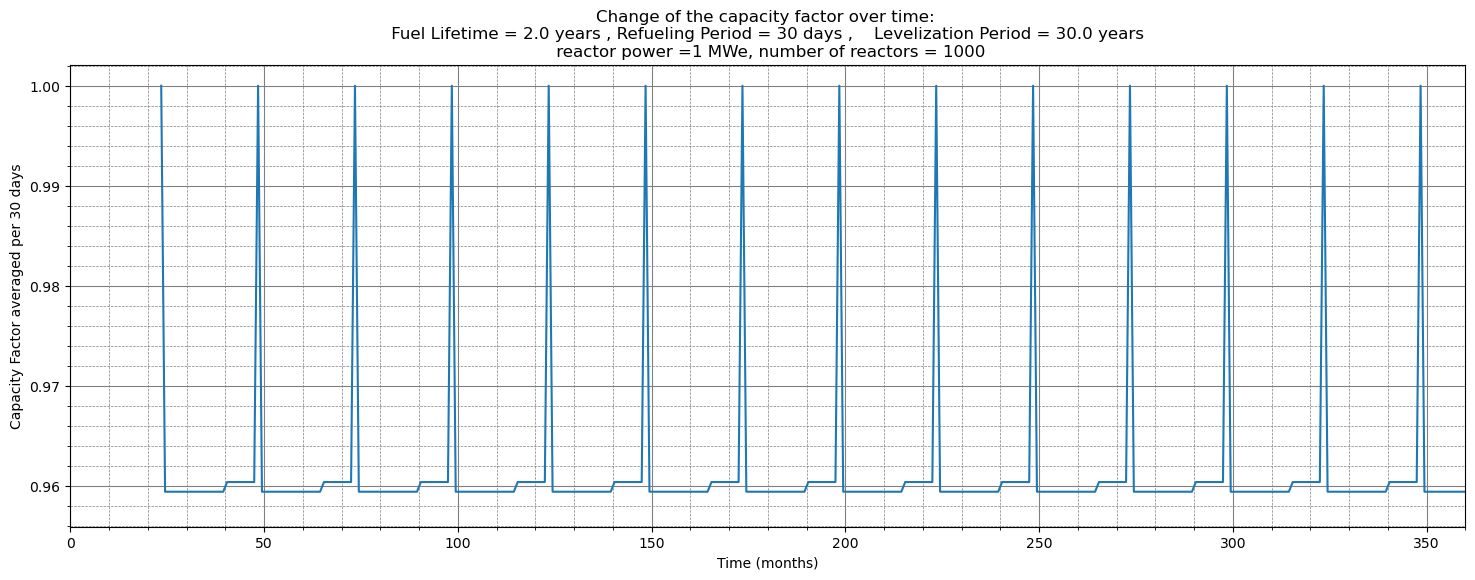

In [10]:
fig = plt.figure(figsize=(18, 6))


# capacity factor averaged over a period
averaging_period = 30
capacity_factor_t
capacity_factor_t_averaged = [statistics.mean(capacity_factor_t[i:i + averaging_period]) for i in range(0, len(capacity_factor_t), averaging_period)]
times_array_excludingRampUp_averaged = [statistics.mean(times_array_excludingRampUp[i:i + averaging_period]) for i in range(0, len(times_array_excludingRampUp), averaging_period)]

plt.plot([x/30 for x in times_array_excludingRampUp_averaged]  , capacity_factor_t_averaged)

plt.xlabel('Time (months)')
plt.ylabel(f'Capacity Factor averaged per {averaging_period } days')
plt.title(f"Change of the capacity factor over time: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days ,\
    Levelization Period = {np.round(levelization_period/365, 1)} years \n reactor power ={ power1} MWe, number of reactors = {num_reactors}")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.xlim(0, 360)
plt.minorticks_on()

plt.show()


# Capacity Factor

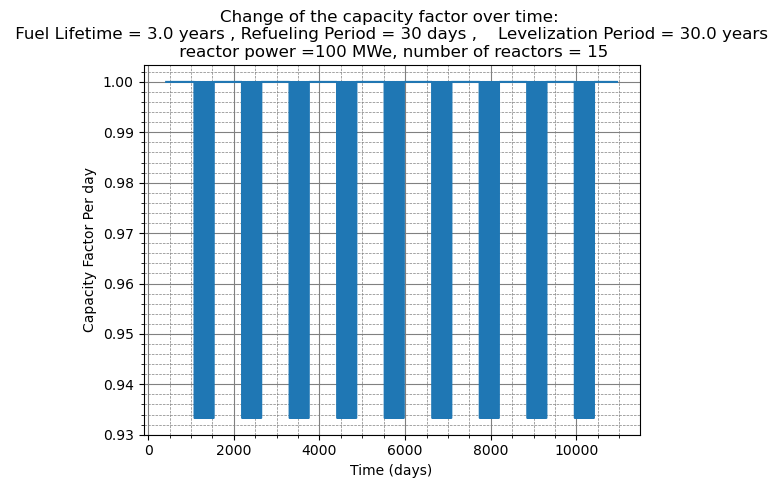

Capacity Factor over the plant lifetime is : 0.9752160288671541


In [11]:
fuel_lifetime = 30 * 12* 3 # days
refueling_period = 30 # days
num_reactors = 15
power1 = 100
levelization_period = 30*365


times_array_excludingRampUp = (capacity_factor(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period, power1*num_reactors ))[0]
capacity_factor_t = (capacity_factor(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period, power1*num_reactors ))[1]
overall_capacity_factor   = (capacity_factor(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period , power1*num_reactors ))[2]


plt.plot(times_array_excludingRampUp, capacity_factor_t )

plt.xlabel('Time (days)')
plt.ylabel('Capacity Factor Per day')
plt.title(f"Change of the capacity factor over time: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days ,\
    Levelization Period = {np.round(levelization_period/365, 1)} years \n reactor power ={ power1} MWe, number of reactors = {num_reactors}")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.show()


print(f"Capacity Factor over the plant lifetime is : {overall_capacity_factor }")

In [20]:
# number of reactors to achieve the target demand 
refueling_period = 30 # days
levelization_period = 30*365

fuel_lifetime = 2*12*30


demand_0 = 1000 # MWe
power_list = [1000, 500, 300, 100, 50, 10, 5, 1]
capacity_factor_criteria_list = [0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]
num_reactors_save_tot = []
for power in power_list :
    num_reactors_save = []
    num_reactors_current = 0 # initialization
    for capacity_factor_criteria in capacity_factor_criteria_list :
    
        num_reactors_0 =  max( int( np.ceil( demand_0 /power)), num_reactors_current)
        for  num_reactors in np.linspace( num_reactors_0 , 2*num_reactors_0, 1+num_reactors_0):
            
                
            times_array_excludingRampUp = (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
            # capacity_factor_min =        min ((capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
            overall_capacity_factor   =   (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[2]
            print( power, num_reactors, capacity_factor_criteria, overall_capacity_factor  )
            if  overall_capacity_factor>=  capacity_factor_criteria:
                num_reactors_save.append(num_reactors)
                num_reactors_current = int(num_reactors)
                
                break
    
            
    num_reactors_save_tot.append(num_reactors_save)        

1000 1.0 0.9 0.9629257602045476
1000 1.0 0.92 0.9629257602045476
1000 1.0 0.94 0.9629257602045476
1000 1.0 0.96 0.9629257602045476
1000 1.0 0.98 0.9629257602045476
1000 2.0 0.98 1.9256478344473948
1000 2.0 0.99 1.9256478344473948
1000 2.0 0.999 1.9256478344473948
1000 2.0 0.9999 1.9256478344473948
1000 2.0 0.99999 1.9256478344473948
1000 2.0 1 1.9256478344473948
500 2.0 0.9 0.9628239172236974
500 2.0 0.92 0.9628239172236974
500 2.0 0.94 0.9628239172236974
500 2.0 0.96 0.9628239172236974
500 2.0 0.98 0.9628239172236974
500 3.0 0.98 1.4440822697640254
500 3.0 0.99 1.4440822697640254
500 3.0 0.999 1.4440822697640254
500 3.0 0.9999 1.4440822697640254
500 3.0 0.99999 1.4440822697640254
500 3.0 1 1.4440822697640254
300 4.0 0.9 1.1551422520946506
300 4.0 0.92 1.1551422520946506
300 4.0 0.94 1.1551422520946506
300 4.0 0.96 1.1551422520946506
300 4.0 0.98 1.1551422520946506
300 4.0 0.99 1.1551422520946506
300 4.0 0.999 1.1551422520946506
300 4.0 0.9999 1.1551422520946506
300 4.0 0.99999 1.15514

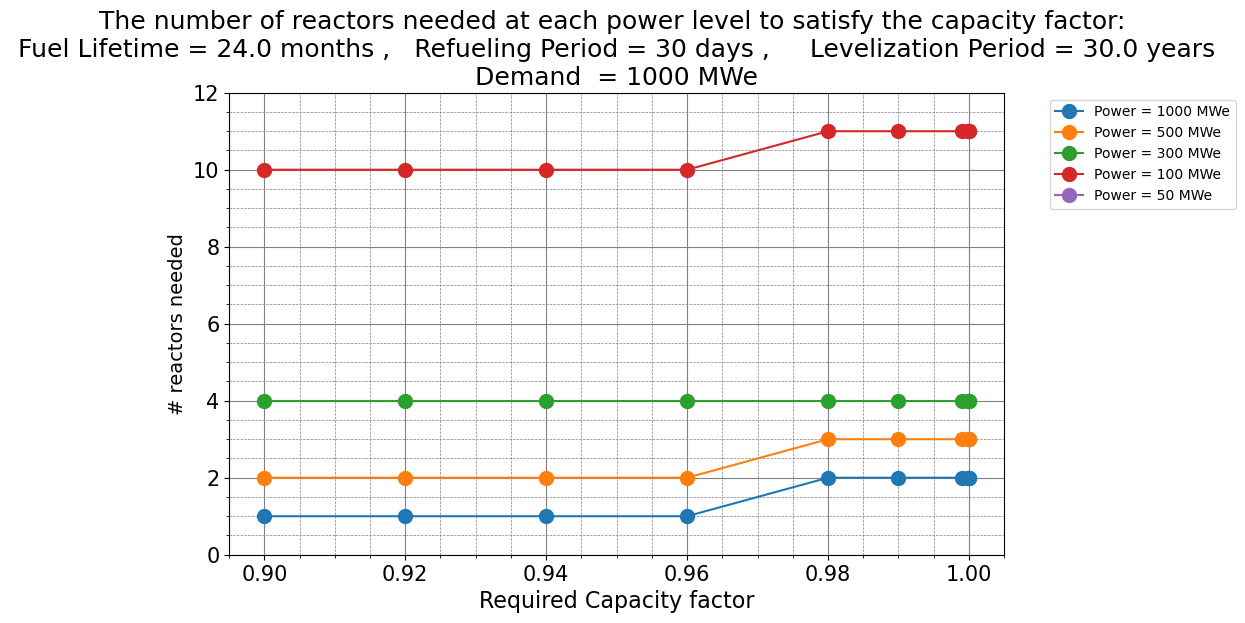

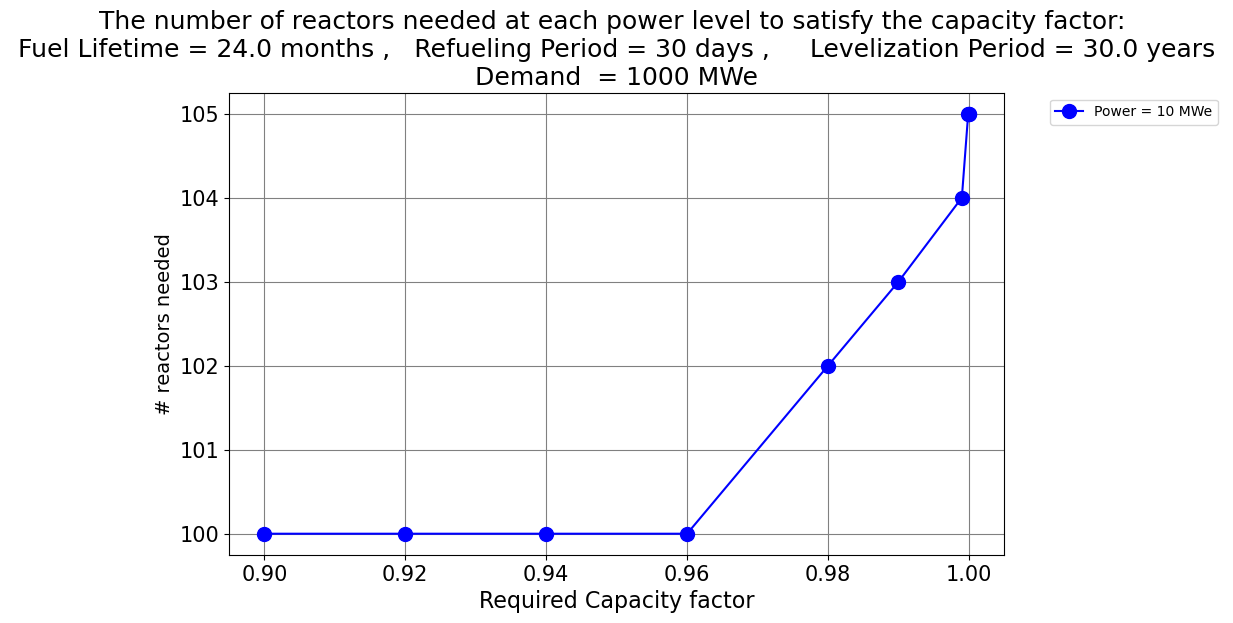

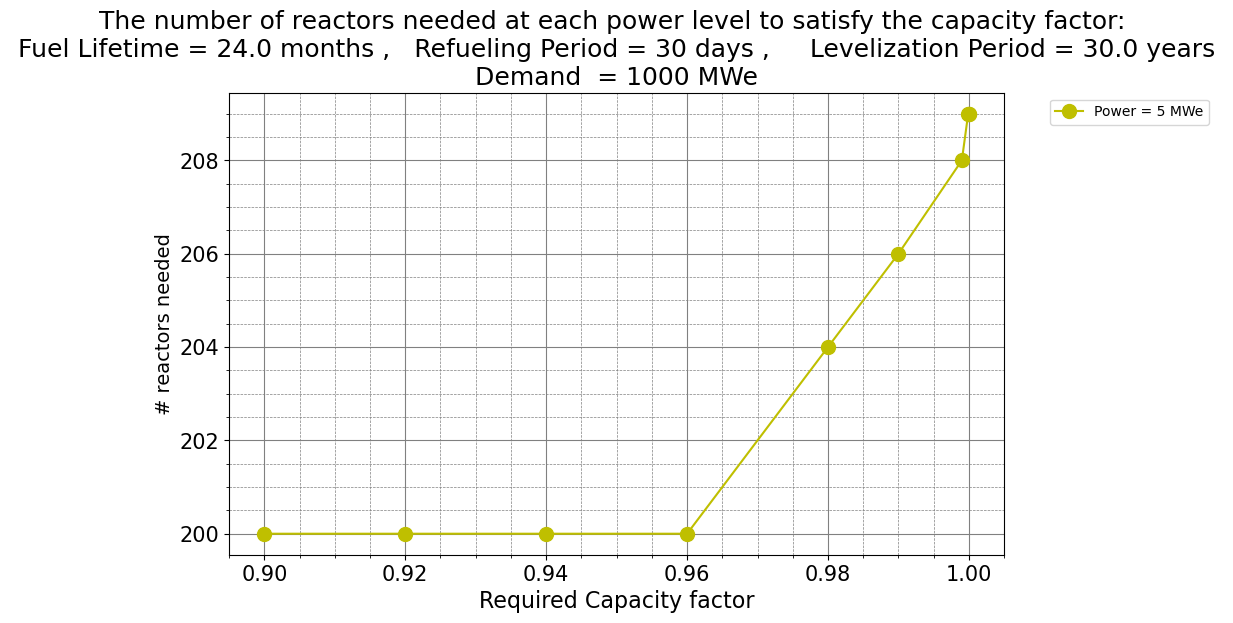

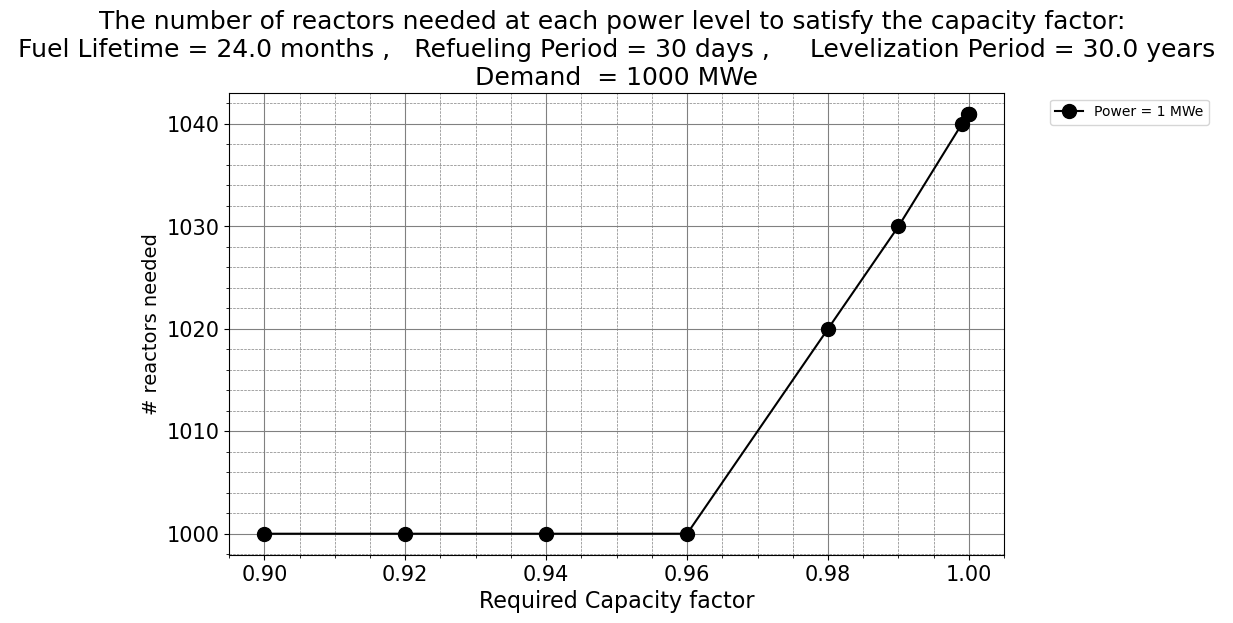

In [ ]:
fig = plt.figure(figsize=(10, 6))



for i in range(len(num_reactors_save_tot) - 3):
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.ylim(0, 22)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('# reactors needed',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()




fig = plt.figure(figsize=(10, 6))


for i in range(5, len(num_reactors_save_tot) -2):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'b',label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# plt.ylim(0, 12)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('# reactors needed',  fontsize=14)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))


plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
# plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()

fig = plt.figure(figsize=(10, 6))
for i in range(6, len(num_reactors_save_tot) -1):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'y',label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('# reactors needed',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()





fig = plt.figure(figsize=(10, 6))
for i in range(7, len(num_reactors_save_tot) ):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'k',label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('# reactors needed',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()



plt.show()

# Minimum Capacity Factor

In [24]:
# number of reactors to achieve the target demand 
refueling_period = 30 # days
levelization_period = 30*365

fuel_lifetime = 2*12*30


demand_0 = 1000 # MWe
power_list = [1000, 500 , 300, 100, 50, 10, 5, 1]
min_capacity_factor_criteria_list = [0.9, 0.92  , 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]

n_reactors_save_tot = []
for power in power_list :
    n_reactors_save = []
    n_reactors_current = 0 # initialization
    for min_capacity_factor_criteria in min_capacity_factor_criteria_list :
    
        n_reactors_0 =  max( int( np.ceil( demand_0 /power)), n_reactors_current)
        for  num_reactors in np.linspace( n_reactors_0 , 2*n_reactors_0, 1+n_reactors_0):
            
                
            times_array_excludingRampUp = (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
            capacity_factor_min =        min ((capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
            print( power, num_reactors, min_capacity_factor_criteria, capacity_factor_min  )
            if  capacity_factor_min >=  min_capacity_factor_criteria:
                n_reactors_save.append(num_reactors)
                n_reactors_current = int(num_reactors)
                
                break
    
            
    n_reactors_save_tot.append(n_reactors_save) 

1000 1.0 0.9 0.0
1000 2.0 0.9 1.0
1000 2.0 0.92 1.0
1000 2.0 0.94 1.0
1000 2.0 0.96 1.0
1000 2.0 0.98 1.0
1000 2.0 0.99 1.0
1000 2.0 0.999 1.0
1000 2.0 0.9999 1.0
1000 2.0 0.99999 1.0
1000 2.0 1 1.0
500 2.0 0.9 0.5
500 3.0 0.9 1.0
500 3.0 0.92 1.0
500 3.0 0.94 1.0
500 3.0 0.96 1.0
500 3.0 0.98 1.0
500 3.0 0.99 1.0
500 3.0 0.999 1.0
500 3.0 0.9999 1.0
500 3.0 0.99999 1.0
500 3.0 1 1.0
300 4.0 0.9 0.9
300 4.0 0.92 0.9
300 5.0 0.92 1.2
300 5.0 0.94 1.2
300 5.0 0.96 1.2
300 5.0 0.98 1.2
300 5.0 0.99 1.2
300 5.0 0.999 1.2
300 5.0 0.9999 1.2
300 5.0 0.99999 1.2
300 5.0 1 1.2
100 10.0 0.9 0.9
100 10.0 0.92 0.9
100 11.0 0.92 1.0
100 11.0 0.94 1.0
100 11.0 0.96 1.0
100 11.0 0.98 1.0
100 11.0 0.99 1.0
100 11.0 0.999 1.0
100 11.0 0.9999 1.0
100 11.0 0.99999 1.0
100 11.0 1 1.0
50 20.0 0.9 0.95
50 20.0 0.92 0.95
50 20.0 0.94 0.95
50 20.0 0.96 0.95
50 21.0 0.96 1.0
50 21.0 0.98 1.0
50 21.0 0.99 1.0
50 21.0 0.999 1.0
50 21.0 0.9999 1.0
50 21.0 0.99999 1.0
50 21.0 1 1.0
10 100.0 0.9 0.95
10 100.0 0.92

In [ ]:
fig = plt.figure(figsize=(18, 6))
power_list = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 10, 5, 1]




plt.plot(power_list,num_reactors_save_sc1,'-o' , markersize = 10, label = "Capacity Factor = 0.99999 , Minimum Capacity Factor per day = 0.999")
plt.plot(power_list,num_reactors_save_sc2, '-*' , markersize = 10, label = "Capacity Factor = 0.95 ,       Minimum Capacity Factor per day = 0.9", color = 'red')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim(45, 1010)
plt.ylim(0, 25)


plt.xlabel('Power(MWe)',  fontsize=16 )
plt.ylabel('# reactors needed to satisfy the capacity factor?',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
    Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

for i in range(len(power_list)): 
    plt.annotate(int(num_reactors_save_sc1[i]), (power_list[i], num_reactors_save_sc1[i] + 0.9) , fontsize=15, color='b')
    plt.annotate(int(num_reactors_save_sc2[i]), (power_list[i]+2, num_reactors_save_sc2[i] - 1.2) , fontsize=15, color='r')

plt.show()



fig = plt.figure(figsize=(18, 6))

plt.plot(power_list,num_reactors_save_sc1,'-o' , markersize = 10, label = "Capacity Factor = 0.99999 , Minimum Capacity Factor per day = 0.999")
plt.plot(power_list,num_reactors_save_sc2, '-*' , markersize = 10, label = "Capacity Factor = 0.95 ,       Minimum Capacity Factor per day = 0.9", color = 'red')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim(1, 10)
plt.ylim(99, 1050)


plt.xlabel('Power(MWe)',  fontsize=16 )
plt.ylabel('# reactors needed to satisfy the capacity factor?',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
    Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)



for i,j in zip(power_list , num_reactors_save_sc1):
    plt.annotate('%s' %int(j), xy=(i,j), xytext=(30,0), textcoords='offset points', fontsize=15, horizontalalignment='left', verticalalignment='bottom', color='b')
    
for i,j in zip(power_list , num_reactors_save_sc2):
    plt.annotate('%s' %int(j), xy=(i,j), xytext=(30,0), textcoords='offset points', fontsize=15, horizontalalignment='right', verticalalignment='top', color='r') 
    
plt.show()